# Attempting to measure the accuracy of volatility indexs
This notebook will look at how to quantify the effectiveness of a calculated index for any point in time. As these indexs are forward looking the performance of a security over the year following the date of observation will be taken.

In [51]:
%load_ext autoreload
%autoreload 2

import metrics_calc
from vix_calc_class import vix_calc
from vix_alternative import vix_alternative

import sqlite3
import pandas as pd
pd.set_option('display.precision', 2)

import seaborn as sns
from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
DT = '2022-01-07'
d = datetime.strptime(DT, '%Y-%m-%d')

V = vix_calc()
data, vix = metrics_calc.observe_vix_acc(DT, v)
data.head(3)

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down,change_ytd
0,476.30,466.09,2022-01-03,2022-01-07,0.00,0.00,466.09,466.09,0.00
1,462.70,464.72,2022-01-10,2022-01-14,0.02,2.51,477.78,454.40,0.29
2,459.74,437.98,2022-01-17,2022-01-21,0.04,3.55,482.62,449.56,6.03


# Aggregate Metrics

In [54]:
# def agg_metrics(df):
#     within, exceeded = metrics_calc.calc_accuracy(df)
#     accuracy = round(within/(within+exceeded), 4)
    
#     stddev = df.close.std()
#     auc, aoc = metrics_calc.calc_auc_aoc(df)
#     yearopen = df.iloc[0].close
#     yearclose = df.iloc[-1].close
#     vixtotal = df.vix_t.sum()
#     return {"accuracy": accuracy, "stddev":stddev, "auc":auc, "aoc":aoc, "yearopen": yearopen,"yearclose":yearclose, "vixtotal":vixtotal}

# def curve_areas(mm, verbose=False):
#     mm['abc'] = mm.auc + mm.aoc
#     mm['rd'] = mm.abc / mm.vixtotal
    
#     if verbose:
#         print(f"Mean Area Under Curve: {mm.auc.mean()}")
#         print(f"Mean Area Over Curve: {mm.aoc.mean()}")
#         print(f"Mean Area Between Curves: {(mm.abc).mean()}")
#         print(f'Ratio : {mm.rd.mean()}')

## Measure Classic VIX

In [55]:
data, vix = metrics_calc.observe_vix_acc(DT, vix_method=V)
vix

18.11287154256035

In [56]:
startdt = '2021-01-08'
startdate = datetime.strptime(startdt, '%Y-%m-%d').date()

enddate = startdate + timedelta(weeks=30)
all_data = {}
metric_data = []
for p in range(52):
    mets = {}
    dt = startdate + timedelta(weeks=p)
    mets['date'] = dt.strftime('%Y-%m-%d')
    data, vix = metrics_calc.observe_vix_acc(dt.strftime('%Y-%m-%d'), vix_method=V)
    mets['vix'] = vix
    
    mets.update(agg_metrics(data))

    metric_data.append(mets)
    all_data[dt.strftime('%Y-%m-%d')] = data


In [57]:
mm = pd.DataFrame.from_dict(metric_data)
mm = mm.dropna()
mm.head(3)

,date,vix,accuracy,stddev,auc,aoc,yearopen,yearclose,vixtotal
0,2021-01-08,21.35,0.77,29.20,114.59,-24.31,381.26,466.09,749.25
1,2021-01-15,23.79,0.75,28.88,94.18,-22.43,375.70,464.72,834.72
2,2021-01-22,21.52,0.74,27.90,106.95,-22.29,382.88,437.98,755.27


In [58]:
metrics_calc.aggregate_metrics.curve_areas(mm, verbose=True)

Mean Area Under Curve: 244.9375741711936
Mean Area Over Curve: -17.32858463565091
Mean Area Between Curves: 227.6089895355427
Ratio : 0.3476427125012004


In [59]:
mm.describe()

,vix,accuracy,stddev,auc,aoc,yearopen,yearclose,vixtotal,abc,rd
count,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00,50.00
mean,19.06,0.86,25.91,244.94,-17.33,426.93,407.63,668.70,227.61,0.35
std,3.87,0.17,5.61,117.92,32.19,28.67,28.15,135.78,140.99,0.21
min,14.67,0.23,16.42,20.11,-173.48,370.07,357.18,514.65,-153.38,-0.26
25%,16.27,0.80,21.29,141.68,-19.40,412.35,388.76,570.87,116.81,0.18
50%,17.97,0.93,27.10,262.75,-2.56,432.53,405.96,630.59,261.33,0.47
75%,20.68,0.98,29.79,318.40,-0.55,445.91,430.90,725.68,314.20,0.52
max,32.42,1.00,34.51,540.91,0.00,474.96,466.09,1137.73,540.91,0.60


# Instant metrics

## A look at implied volatilty as prescribed by the vix over a period of time

In [42]:
all_data.keys()

dict_keys(['2021-01-08', '2021-01-15', '2021-01-22', '2021-01-29', '2021-02-05', '2021-02-12', '2021-02-19', '2021-02-26', '2021-03-05', '2021-03-12', '2021-03-19', '2021-03-26', '2021-04-02', '2021-04-09', '2021-04-16', '2021-04-23', '2021-04-30', '2021-05-07', '2021-05-14', '2021-05-21', '2021-05-28', '2021-06-04', '2021-06-11', '2021-06-18', '2021-06-25', '2021-07-02', '2021-07-09', '2021-07-16', '2021-07-23', '2021-07-30', '2021-08-06', '2021-08-13', '2021-08-20', '2021-08-27', '2021-09-03', '2021-09-10', '2021-09-17', '2021-09-24', '2021-10-01', '2021-10-08', '2021-10-15', '2021-10-22', '2021-10-29', '2021-11-05', '2021-11-12', '2021-11-19', '2021-11-26', '2021-12-03', '2021-12-10', '2021-12-17', '2021-12-24', '2021-12-31'])

24.47717667194873


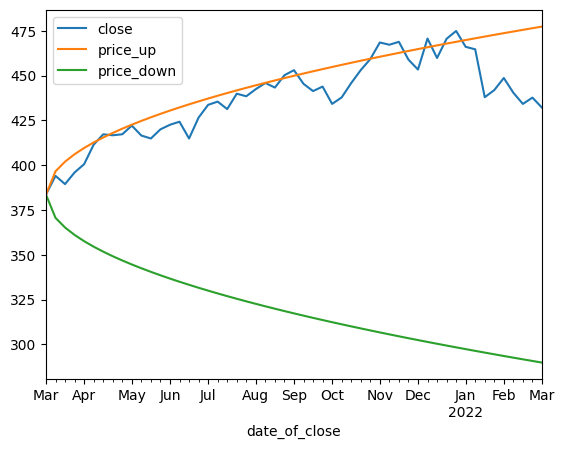

In [72]:
DT = "2021-03-05"
data, VIX = metrics_calc.observe_vix_acc(DT, V)
print(VIX)
data.plot(x='date_of_close', y=['close', 'price_up', 'price_down']);

## A look at the absolute change in the SPY (to date), and the prescribed volatility bound

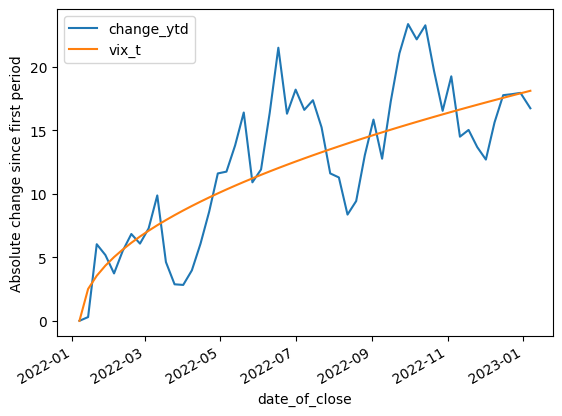

In [154]:
data['change_ytd'] = abs(data.close / data.close.iloc[0] - 1) * 100
ax = data.plot(x='date_of_close', y=['change_ytd', 'vix_t'])
ax.set_ylabel('Absolute change since first period');

## 3 ways of measuring effectiveness for a individual period
1. Count how frequently the SPY leaves the vix bounds
3. Compare Index to the standard deviation of the stocks proven performance
2. Take the difference between the area under the curve for both indexs.

#### Simple Accuracy

In [131]:
df = data[['close', 'date_of_close', 'vix_t', 'change_init']].copy()

# within, exceeded = df.bounded.value_counts().loc[True], df.bounded.value_counts().loc[False]
within, exceeded = metrics_calc.calc_accuracy(df, real_col='change_init')
print('Within Bound:\t', within)
print('Exceeded bound:\t', exceeded)
print('Accuracy: ', round(within/(within+exceeded)*100, 2))

Within Bound:	 24
Exceeded bound:	 29
Accuracy:  45.28


#### Standard Deviation
Note: As the standard deviation is an annualised value, for any given point, the difference between the VIX and the STD for the following year can be compared.

In [132]:
df.close.std()

28.372731765507627

In [133]:
print('Standard Deviation:\t\t', df.close.std())
print('Relative Standard Deviation:\t', df.close.std() / df.close.mean() * 100)

Standard Deviation:		 28.372731765507627
Relative Standard Deviation:	 6.960094122722693


#### Area Under the curve

In [136]:
df.change_init.std()

6.087393371560778

In [106]:
data.vix_t.sum() - data.change_init.sum()

528.0267615239161

In [107]:
data['curve_diff'] = data.vix_t - data.change_init

In [113]:
metrics_calc.calc_auc(data, real_col='change_init', vix_t='vix_t')

(528.0267615239163, 0.0)

In [108]:
data[data.curve_diff > 0].curve_diff.sum()

528.0267615239163

In [110]:
data.head()

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down,change_init,curve_diff
0,459.74,437.98,2022-01-17,2022-01-21,0.000000,0.000000,437.980000,437.980000,0.000000,0.000000
1,432.03,441.95,2022-01-24,2022-01-28,0.019178,3.768618,454.485792,421.474208,0.906434,2.862184
2,441.24,448.70,2022-01-31,2022-02-04,0.038356,5.329630,461.322714,414.637286,2.447600,2.882030
3,449.51,440.46,2022-02-07,2022-02-11,0.057534,6.527437,466.568870,409.391130,0.566236,5.961201
4,439.92,434.23,2022-02-14,2022-02-18,0.076712,7.537235,470.991583,404.968417,0.856203,6.681032
